In [1]:
import numpy as np
from keras.datasets import mnist
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchvision import transforms
import torch.nn as nn
from torch.utils.data import DataLoader,Dataset
import torch
import torch.optim as optim
from torch.autograd import Variable

In [2]:
"""
Here we load the dataset, add gaussian,poisson,speckle

    'gauss'     Gaussian-distributed additive noise.
    'speckle'   Multiplicative noise using out = image + n*image,where
                n is uniform noise with specified mean & variance.
                
We define a function that adds each noise when called from main function
Input & Output: np array
                
"""


def add_noise(img,noise_type="gaussian"):
  
  row,col=28,28 # 28 is the image shape
  img=img.astype(np.float32)
  
  if noise_type=="gaussian":
    mean=0
    var=10
    sigma=var**.5
    noise=np.random.normal(-5.9,5.9,img.shape)
    noise=noise.reshape(row,col)
    img=img+noise
    return img

  if noise_type=="speckle":
    noise=np.random.randn(row,col)
    noise=noise.reshape(row,col)
    img=img+img*noise
    return img


In [3]:
#Here we load the dataset from keras
(xtrain,ytrain),(xtest,ytest)=mnist.load_data()
print("No of training datapoints:{}\nNo of Test datapoints:{}".format(len(xtrain),len(xtest)))
print(xtrain.shape)

No of training datapoints:60000
No of Test datapoints:10000
(60000, 28, 28)


In [4]:
"""
From here onwards,we split the 60k training datapoints into 3 sets each given one type of each noise.
We shuffle them for better generalization.
"""
noises=["gaussian","speckle"]
noise_ct=0
noise_id=0
traindata=np.zeros((60000,28,28))


for idx in tqdm(range(len(xtrain))):
  
  if noise_ct<(len(xtrain)/2):
    noise_ct+=1
    traindata[idx]=add_noise(xtrain[idx],noise_type=noises[noise_id])
    
  else:
    print("\n{} noise addition completed to images".format(noises[noise_id]))
    noise_id+=1
    noise_ct=0


print("\n{} noise addition completed to images".format(noises[noise_id])) 




noise_ct=0
noise_id=0
testdata=np.zeros((10000,28,28))

for idx in tqdm(range(len(xtest))):
  if noise_ct<(len(xtest)/2):
    noise_ct+=1
    x=add_noise(xtest[idx],noise_type=noises[noise_id])
    testdata[idx]=x
    
  else:
    print("\n{} noise addition completed to images".format(noises[noise_id]))
    noise_id+=1
    noise_ct=0


print("\n{} noise addition completed to images".format(noises[noise_id]))    
  

 58%|██████████████████████████████████████████▌                              | 34934/60000 [00:01<00:00, 25236.33it/s]


gaussian noise addition completed to images


100%|█████████████████████████████████████████████████████████████████████████| 60000/60000 [00:02<00:00, 24047.18it/s]



speckle noise addition completed to images


100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 23166.86it/s]


gaussian noise addition completed to images

speckle noise addition completed to images


Text(0.5, 1.0, 'Noised Image')

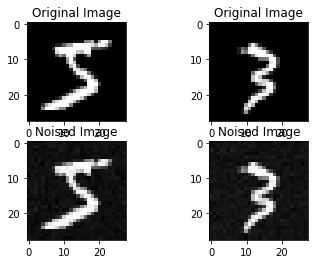

In [5]:
"""
Here we Try to visualize, each type of noise that was introduced in the images
Along with their original versions

"""

f, axes=plt.subplots(2,2)

#showing images with gaussian noise
axes[0,0].imshow(xtrain[0],cmap="gray")
axes[0,0].set_title("Original Image")
axes[1,0].imshow(traindata[0],cmap='gray')
axes[1,0].set_title("Noised Image")

#showing images with speckle noise
axes[0,1].imshow(xtrain[25000],cmap='gray')
axes[0,1].set_title("Original Image")
axes[1,1].imshow(traindata[25000],cmap="gray")
axes[1,1].set_title("Noised Image")



In [6]:
class noisedDataset(Dataset):
  
  def __init__(self,datasetnoised,datasetclean,labels,transform):
    self.noise=datasetnoised
    self.clean=datasetclean
    self.labels=labels
    self.transform=transform
  
  def __len__(self):
    return len(self.noise)
  
  def __getitem__(self,idx):
    xNoise=self.noise[idx]
    xClean=self.clean[idx]
    y=self.labels[idx]
    
    if self.transform != None:
      xNoise=self.transform(xNoise)
      xClean=self.transform(xClean)
      
    
    return (xNoise,xClean,y)
      
  
    

In [7]:
tsfms=transforms.Compose([
    transforms.ToTensor()
])

trainset=noisedDataset(traindata,xtrain,ytrain,tsfms)
testset=noisedDataset(testdata,xtest,ytest,tsfms)

In [8]:
"""
Here , we create the trainloaders and testloaders.
Also, we transform the images using standard lib functions
"""


batch_size=32



trainloader=DataLoader(trainset,batch_size=32,shuffle=True)
testloader=DataLoader(testset,batch_size=1,shuffle=True)



In [14]:
"""
Here, we define the autoencoder model.
"""

test = transforms.ToTensor()(traindata[0].astype(np.float32))
test = test.reshape(-1)
print(test.shape)
linear1 = nn.Linear(28*28,256)
print(linear1(test).shape)

class denoising_model(nn.Module):
  def __init__(self):
    super(denoising_model,self).__init__()
    self.encoder=nn.Sequential(
                  nn.Linear(28*28,256),
                  nn.ReLU(True),
                  nn.Linear(256,128),
                  nn.ReLU(True),
                  nn.Linear(128,64),
                  nn.ReLU(True)
        
                  )
    
    self.decoder=nn.Sequential(
                  nn.Linear(64,128),
                  nn.ReLU(True),
                  nn.Linear(128,256),
                  nn.ReLU(True),
                  nn.Linear(256,28*28),
                  nn.Sigmoid(),
                  )
    
 
  def forward(self,x):
    x=self.encoder(x)
    x=self.decoder(x)
    
    return x
  

torch.Size([784])
torch.Size([256])


In [19]:
#We check whether cuda is available and choose device accordingly
if torch.cuda.is_available()==True:
  device="cuda:0"
else:
  device ="cpu"

  
model=denoising_model().to(device)
criterion=nn.MSELoss()
optimizer=optim.SGD(model.parameters(),lr=0.01,weight_decay=1e-5)
    
epochs=50
l=len(trainloader)
losslist=list()
epochloss=0
running_loss=0
for epoch in range(epochs):
  
  print("Entering Epoch: ",epoch)
  for dirty,clean,label in tqdm((trainloader)):
    
    
    dirty=dirty.view(dirty.size(0),-1).type(torch.FloatTensor)
    clean=clean.view(clean.size(0),-1).type(torch.FloatTensor)
    dirty,clean=dirty.to(device),clean.to(device)
    
    
    
    #-----------------Forward Pass----------------------
    output=model(dirty)
    loss=criterion(output,clean)
    #-----------------Backward Pass---------------------
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    running_loss+=loss.item()
    epochloss+=loss.item()
  #-----------------Log-------------------------------
  losslist.append(running_loss/l)
  running_loss=0
  print("======> epoch: {}/{}, Loss:{}".format(epoch,epochs,loss.item()))
    
    
      
      
    

 

Entering Epoch:  0


100%|█████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:06<00:00, 273.74it/s]


======> epoch: 0/50, Loss:0.07100880891084671
Entering Epoch:  1


100%|█████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:06<00:00, 276.33it/s]


======> epoch: 1/50, Loss:0.0701112449169159
Entering Epoch:  2


100%|█████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:06<00:00, 277.88it/s]


======> epoch: 2/50, Loss:0.06116991490125656
Entering Epoch:  3


100%|█████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:09<00:00, 203.61it/s]


======> epoch: 3/50, Loss:0.06527695059776306
Entering Epoch:  4


100%|█████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:09<00:00, 207.67it/s]


======> epoch: 4/50, Loss:0.05550166964530945
Entering Epoch:  5


100%|█████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:09<00:00, 197.38it/s]


======> epoch: 5/50, Loss:0.05160706490278244
Entering Epoch:  6


100%|█████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:10<00:00, 183.05it/s]


======> epoch: 6/50, Loss:0.05658528208732605
Entering Epoch:  7


100%|█████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:10<00:00, 171.32it/s]


======> epoch: 7/50, Loss:0.050951093435287476
Entering Epoch:  8


100%|█████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:11<00:00, 157.00it/s]


======> epoch: 8/50, Loss:0.05001179501414299
Entering Epoch:  9


100%|█████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:10<00:00, 174.19it/s]


======> epoch: 9/50, Loss:0.042946115136146545
Entering Epoch:  10


100%|█████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:11<00:00, 164.10it/s]


======> epoch: 10/50, Loss:0.03844500705599785
Entering Epoch:  11


100%|█████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:10<00:00, 173.65it/s]


======> epoch: 11/50, Loss:0.039275433868169785
Entering Epoch:  12


100%|█████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:12<00:00, 151.05it/s]


======> epoch: 12/50, Loss:0.0463283434510231
Entering Epoch:  13


100%|█████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:11<00:00, 157.03it/s]


======> epoch: 13/50, Loss:0.04130829498171806
Entering Epoch:  14


100%|█████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:10<00:00, 170.73it/s]


======> epoch: 14/50, Loss:0.04092862084507942
Entering Epoch:  15


100%|█████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:10<00:00, 172.34it/s]


======> epoch: 15/50, Loss:0.04365471750497818
Entering Epoch:  16


100%|█████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:11<00:00, 161.36it/s]


======> epoch: 16/50, Loss:0.0408819317817688
Entering Epoch:  17


100%|█████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:11<00:00, 168.74it/s]


======> epoch: 17/50, Loss:0.04154667630791664
Entering Epoch:  18


100%|█████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:10<00:00, 173.49it/s]


======> epoch: 18/50, Loss:0.03853350877761841
Entering Epoch:  19


100%|█████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:11<00:00, 169.82it/s]


======> epoch: 19/50, Loss:0.04101761057972908
Entering Epoch:  20


100%|█████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:12<00:00, 147.12it/s]


======> epoch: 20/50, Loss:0.03549058735370636
Entering Epoch:  21


100%|█████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:12<00:00, 156.18it/s]


======> epoch: 21/50, Loss:0.03817763924598694
Entering Epoch:  22


100%|█████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:11<00:00, 157.81it/s]


======> epoch: 22/50, Loss:0.03610233962535858
Entering Epoch:  23


100%|█████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:11<00:00, 168.76it/s]


======> epoch: 23/50, Loss:0.03645961731672287
Entering Epoch:  24


100%|█████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:10<00:00, 171.62it/s]


======> epoch: 24/50, Loss:0.03584948554635048
Entering Epoch:  25


100%|█████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:10<00:00, 171.52it/s]


======> epoch: 25/50, Loss:0.03199123218655586
Entering Epoch:  26


100%|█████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:10<00:00, 171.08it/s]


======> epoch: 26/50, Loss:0.030439473688602448
Entering Epoch:  27


100%|█████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:10<00:00, 171.48it/s]


======> epoch: 27/50, Loss:0.03152823820710182
Entering Epoch:  28


100%|█████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:10<00:00, 170.89it/s]


======> epoch: 28/50, Loss:0.035771287977695465
Entering Epoch:  29


100%|█████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:11<00:00, 167.19it/s]


======> epoch: 29/50, Loss:0.03624818101525307
Entering Epoch:  30


100%|█████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:11<00:00, 168.82it/s]


======> epoch: 30/50, Loss:0.028933946043252945
Entering Epoch:  31


100%|█████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:10<00:00, 170.63it/s]


======> epoch: 31/50, Loss:0.032333482056856155
Entering Epoch:  32


100%|█████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:11<00:00, 165.87it/s]


======> epoch: 32/50, Loss:0.031193463131785393
Entering Epoch:  33


100%|█████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:11<00:00, 164.24it/s]


======> epoch: 33/50, Loss:0.029864687472581863
Entering Epoch:  34


100%|█████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:11<00:00, 169.46it/s]


======> epoch: 34/50, Loss:0.03147996589541435
Entering Epoch:  35


100%|█████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:11<00:00, 169.20it/s]


======> epoch: 35/50, Loss:0.03233357146382332
Entering Epoch:  36


100%|█████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:11<00:00, 168.81it/s]


======> epoch: 36/50, Loss:0.03246006742119789
Entering Epoch:  37


100%|█████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:11<00:00, 168.57it/s]


======> epoch: 37/50, Loss:0.02747667394578457
Entering Epoch:  38


100%|█████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:11<00:00, 168.59it/s]


======> epoch: 38/50, Loss:0.03442193940281868
Entering Epoch:  39


100%|█████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:11<00:00, 169.33it/s]


======> epoch: 39/50, Loss:0.028281789273023605
Entering Epoch:  40


100%|█████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:11<00:00, 168.62it/s]


======> epoch: 40/50, Loss:0.026979200541973114
Entering Epoch:  41


100%|█████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:11<00:00, 169.34it/s]


======> epoch: 41/50, Loss:0.027914268895983696
Entering Epoch:  42


100%|█████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:11<00:00, 168.62it/s]


======> epoch: 42/50, Loss:0.029941082000732422
Entering Epoch:  43


100%|█████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:11<00:00, 168.49it/s]


======> epoch: 43/50, Loss:0.02984975092113018
Entering Epoch:  44


100%|█████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:11<00:00, 163.94it/s]


======> epoch: 44/50, Loss:0.02986631914973259
Entering Epoch:  45


100%|█████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:11<00:00, 168.49it/s]


======> epoch: 45/50, Loss:0.028734005987644196
Entering Epoch:  46


100%|█████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:11<00:00, 168.28it/s]


======> epoch: 46/50, Loss:0.02560020424425602
Entering Epoch:  47


100%|█████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:11<00:00, 169.34it/s]


======> epoch: 47/50, Loss:0.02705192379653454
Entering Epoch:  48


100%|█████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:11<00:00, 168.98it/s]


======> epoch: 48/50, Loss:0.028330598026514053
Entering Epoch:  49


100%|█████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:11<00:00, 168.82it/s]

======> epoch: 49/50, Loss:0.024014679715037346


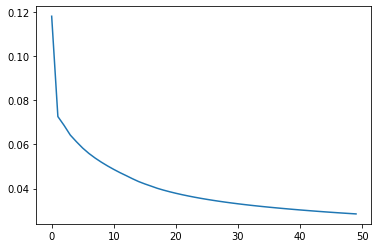

In [11]:
plt.plot(range(len(losslist)),losslist)

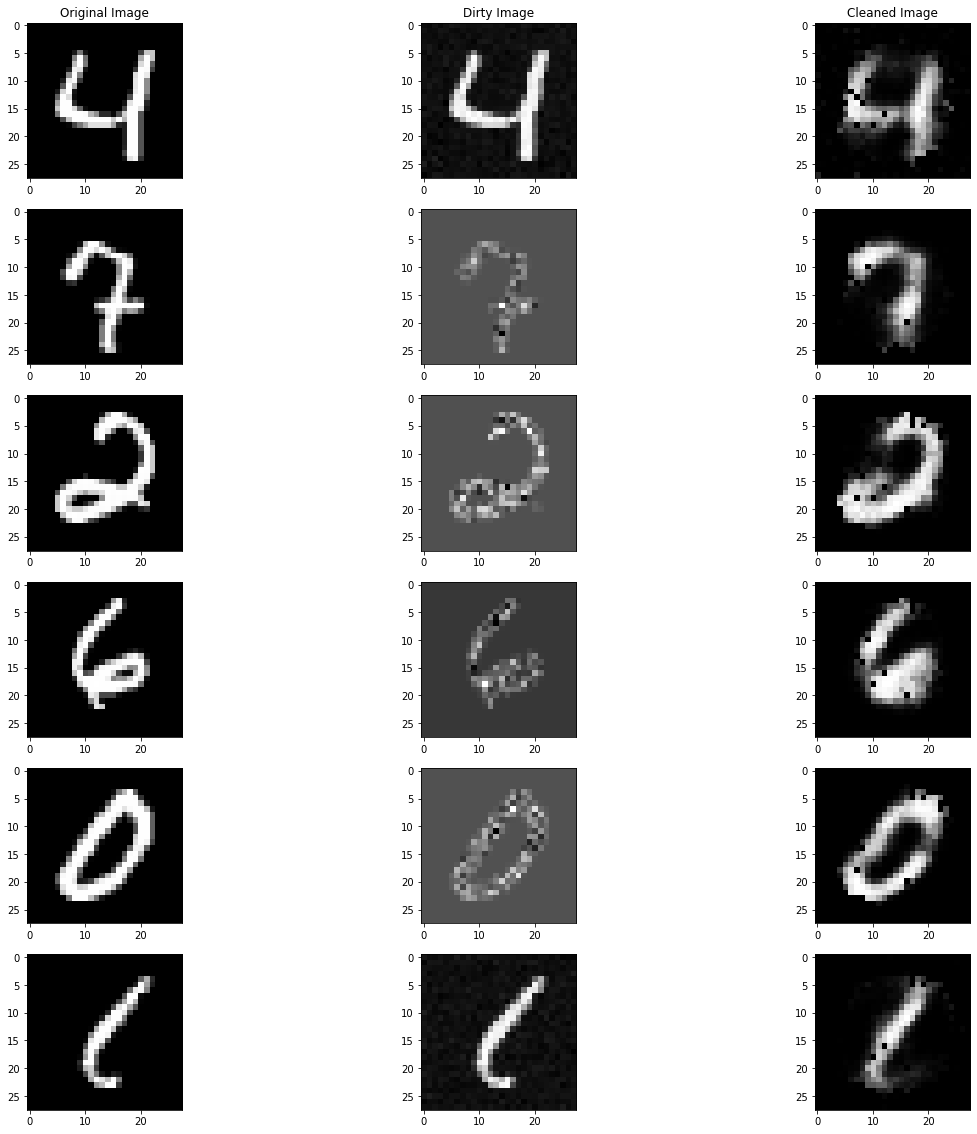

In [12]:
"""Here, we try to visualize some of the results.
  We randomly generate 6 numbers in between 1 and 10k , run them through the model,
  and show the results with comparisons
  
 """




f,axes= plt.subplots(6,3,figsize=(20,20))
axes[0,0].set_title("Original Image")
axes[0,1].set_title("Dirty Image")
axes[0,2].set_title("Cleaned Image")

test_imgs=np.random.randint(0,10000,size=6)
for idx in range((6)):
  dirty=testset[test_imgs[idx]][0]
  clean=testset[test_imgs[idx]][1]
  label=testset[test_imgs[idx]][2]
  dirty=dirty.view(dirty.size(0),-1).type(torch.FloatTensor)
  dirty=dirty.to(device)
  output=model(dirty)
  
  output=output.view(1,28,28)
  output=output.permute(1,2,0).squeeze(2)
  output=output.detach().cpu().numpy()
  
  dirty=dirty.view(1,28,28)
  dirty=dirty.permute(1,2,0).squeeze(2)
  dirty=dirty.detach().cpu().numpy()
  
  clean=clean.permute(1,2,0).squeeze(2)
  clean=clean.detach().cpu().numpy()
  
  axes[idx,0].imshow(clean,cmap="gray")
  axes[idx,1].imshow(dirty,cmap="gray")
  axes[idx,2].imshow(output,cmap="gray")
  


  
  
  
  

In [ ]:
torch.save(model.state_dict(),"./")  # We save the model state dict at PATH   